In [42]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [43]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

dataset_path = kagglehub.dataset_download('chethuhn/network-intrusion-dataset')
model_path = kagglehub.dataset_download('fikrimulyanasetiawan/rnn-model')
encoder_path = kagglehub.dataset_download('fikrimulyanasetiawan/encoder')

print('Data source import complete. \n')
print("Information about your data sources:")
print(f"Dataset path: {dataset_path}")
print(f"Model path: {model_path}")
print(f"Encoder path: {encoder_path}")


Data source import complete. 

Information about your data sources:
Dataset path: /kaggle/input/network-intrusion-dataset
Model path: /root/.cache/kagglehub/datasets/fikrimulyanasetiawan/rnn-model/versions/1
Encoder path: /root/.cache/kagglehub/datasets/fikrimulyanasetiawan/encoder/versions/1


# Intrusion Detection System

## Import Library

In [44]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


## Preprocessing Data

### Load Data

In [45]:
# Fungsi untuk membaca dan preprocessing setiap file
def read_and_clean_file(file_path):
    print(f"Membaca file: {file_path}")
    df = pd.read_csv(file_path, low_memory=False, sep=",")

    # Bersihkan nama kolom dari whitespace
    df.columns = df.columns.str.strip()

    # Hapus kolom yang tidak diperlukan
    redundant_column = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
                 'Destination Port', 'Protocol', 'Timestamp']
    df = df.drop(redundant_column, axis=1, errors='ignore')

    # drop baris yang tidak punya label
    df.dropna(subset = ['Label'], inplace=True)

    # Handling missing values dan infinite values
    df = df.replace([np.inf, -np.inf], np.nan)

    return df


# Baca semua file CSV dari folder
data1 = dataset_path + "/Monday-WorkingHours.pcap_ISCX.csv"
data2 = dataset_path + "/Tuesday-WorkingHours.pcap_ISCX.csv"
data3 = dataset_path + "/Wednesday-workingHours.pcap_ISCX.csv"
data4 = dataset_path + "/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
data5 = dataset_path + "/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
data6 = dataset_path + "/Friday-WorkingHours-Morning.pcap_ISCX.csv"
data7 = dataset_path + "/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
data8 = dataset_path + "/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"


# Buat list semua dataset yang tersedia
all_files = [data2, data3, data4, data5, data6, data7, data8]

# Membaca file dan mengkonversi semua data file dari list "all_files" menjadi dataframe
dataframes = []
for file in all_files:
    df = read_and_clean_file(file)
    dataframes.append(df)
    del df

Membaca file: /kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


In [46]:
# Menggabungkan semua dataframe
print("Menggabungkan semua file...")
df = pd.concat(dataframes, ignore_index=True)
try:
    print("Semua file dataset berhasil digabungkan!")
except:
    print("Error! file dataset tidak berhasil digabungkan")

Menggabungkan semua file...
Semua file dataset berhasil digabungkan!


### Pembersihan Data Duplikat

In [47]:
# ganti nama kolom dengan cara hapus whitespaces
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

# informasi data duplikat
dups = df[df.duplicated()]
print(f'Banyak data duplikat : {len(dups)}')
print(f'Banyak data sebelum duplikat : {df.shape[0]}')

print("menghapus data duplikat...")

# Hapus data duplikat
df.drop_duplicates(inplace = True)
print("data duplikat selesai dihapus!")
df.shape
print(f"banyak data setelah data duplikat dihapus : {df.shape[0]}")

Banyak data duplikat : 524101
Banyak data sebelum duplikat : 2300825
menghapus data duplikat...
data duplikat selesai dihapus!
banyak data setelah data duplikat dihapus : 1776724


### Persiapan Label Kelas untuk Klasifikasi Biner

In [48]:
# konversi semua label selain BENIGN jadi ATTACK
df["Label"] = df["Label"].where(df["Label"] == "BENIGN", "ATTACK")
print("Informasi Kelas : ")
df["Label"].unique()

Informasi Kelas : 


array(['BENIGN', 'ATTACK'], dtype=object)

## Informasi Umum Dataset

In [49]:
# Menampilkan informasi dataset
print("\nInformasi Dataset:")
print(f"\nJumlah total data: {len(df)}")
print(f"Jumlah fitur : {len(df.columns)}")
print("\nDistribusi Label sebelum preprocessing:")

# tabel distribusi label
def create_distribution_table(df):
    label_dist = pd.DataFrame(df['Label'].value_counts())
    label_dist['percentage'] = df['Label'].value_counts()/len(df)
    return label_dist

create_distribution_table(df)


Informasi Dataset:

Jumlah total data: 1776724
Jumlah fitur : 78

Distribusi Label sebelum preprocessing:


,count,percentage
Label,,
BENIGN,1440219,0.810604
ATTACK,336505,0.189396


In [50]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,640,7,4,440,358,220,0,62.857143,107.349008,179,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,900,9,4,600,2944,300,0,66.666667,132.287566,1472,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,511,7,4,452,370,226,0,64.571429,110.276708,185,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,773,9,4,612,2944,306,0,68.000000,134.933317,1472,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300812,4,2,0,0,0,0,0,0.000000,0.000000,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2300814,22,1,1,0,0,0,0,0.000000,0.000000,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2300816,45,1,1,0,0,0,0,0.000000,0.000000,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2300823,48,2,0,12,0,6,6,6.000000,0.000000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [51]:
# Menampilkan informasi dataset
print("\nInformasi Dataset:")
print(f"\nJumlah total data: {len(df)}")
print(f"Jumlah fitur : {len(df.columns)}")
print("\nDistribusi Label setelah preprocessing:")

create_distribution_table(df)


Informasi Dataset:

Jumlah total data: 1776724
Jumlah fitur : 78

Distribusi Label setelah preprocessing:


,count,percentage
Label,,
BENIGN,1440219,0.810604
ATTACK,336505,0.189396


## Pemisahan Data Fitur (X) dan Ouput (y)

In [52]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
X = df[numerical_columns]
y = df["Label"]
print(f"jumlah fitur : {len(X.columns)}")
print(f"jumlah label : {len(y.unique())}")

jumlah fitur : 77
jumlah label : 2


## Training-Test Split

In [53]:
tss = TimeSeriesSplit(n_splits=7)
print(tss)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None)


In [54]:
#X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
train_index, test_index = [], []
for i, (train_interval, test_interval) in enumerate(tss.split(X)):
    print(f"fold {i}:")
    print(f"  Train: index : from {train_interval.min()} up to {train_interval.max()}")
    print(f"  Test:  index=from {test_interval.min()} up to {test_interval.max()}")
    print(f"  Jumlah kelas pada training set : {y.iloc[train_interval].nunique()}")
    print(f"  Jumlah kelas pada testing set : {y.iloc[test_interval].nunique()}")
    train_index, test_index = train_interval, test_interval


fold 0:
  Train: index : from 0 up to 222093
  Test:  index=from 222094 up to 444183
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 1:
  Train: index : from 0 up to 444183
  Test:  index=from 444184 up to 666273
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 2:
  Train: index : from 0 up to 666273
  Test:  index=from 666274 up to 888363
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 3:
  Train: index : from 0 up to 888363
  Test:  index=from 888364 up to 1110453
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 4:
  Train: index : from 0 up to 1110453
  Test:  index=from 1110454 up to 1332543
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 5:
  Train: index : from 0 up to 1332543
  Test:  index=from 1332544 up to 1554633
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 6:
  Train: index : from 0 up to 1554633

In [55]:
# Split dataset dengan stratifikasi
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test  = y.iloc[train_index], y.iloc[test_index]

In [56]:
y_test.value_counts()

,count
Label,
ATTACK,128162
BENIGN,93928


In [57]:
y_train.value_counts()

,count
Label,
BENIGN,1346291
ATTACK,208343


## Transformasi Data

In [58]:
# imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
print("fitting imputer...")
imputer.fit(X_train)
print("selesai!")

# scaler
scaler = StandardScaler(copy=False)
print("\nfitting scaler...")
scaler.fit(X_train)
print("selesai!")

# label encoder (le)
le = LabelEncoder()
print("\nfitting label encoder...")
le.fit(y_train.astype(str))
print("selesai!")

fitting imputer...
selesai!

fitting scaler...
selesai!

fitting label encoder...
selesai!


In [59]:
for i, label in enumerate(le.classes_):
    print(f"i : {i} , label : {label}")

i : 0 , label : ATTACK
i : 1 , label : BENIGN


In [60]:
# Menampilkan informasi kelas
print("\nKelas yang terdeteksi:")
for i, label in enumerate(le.classes_):
    count = (df["Label"] == i).sum()
    print(f"{label}: {count} samples (encoded as {i})")



Kelas yang terdeteksi:
ATTACK: 0 samples (encoded as 0)
BENIGN: 0 samples (encoded as 1)


In [61]:
df["Label"].value_counts()

,count
Label,
BENIGN,1440219
ATTACK,336505


In [62]:
def transform_data(X, y, scaler, imputer, le):
    # Handling missing values untuk dataset training
    print("\nMenangani missing values...")
    X = imputer.transform(X)
    print("selesai!")

    # Normalisasi Data
    print("\nMelakukan normalisasi data...")
    X = scaler.transform(X)
    print("selesai!")

    # Pelabelan Kelas
    num_classes = len(le.classes_)
    print("\nMelakukan one-hot encoding...")
    y = le.transform(y)
    print("selesai!")

    return X, y

In [63]:
## Transformasi Data Training
X_train, y_train = transform_data(X_train, y_train, scaler, imputer, le)

# Transformmasi data testing
X_test, y_test = transform_data(X_test, y_test, scaler, imputer, le)


Menangani missing values...
selesai!

Melakukan normalisasi data...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


selesai!

Melakukan one-hot encoding...
selesai!

Menangani missing values...
selesai!

Melakukan normalisasi data...
selesai!

Melakukan one-hot encoding...
selesai!


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Feature Selection

In [64]:
# prompt: lakukan feature selection menggunakan anova f-test

from sklearn.feature_selection import SelectKBest, f_classif

# Lakukan feature selection menggunakan ANOVA F-test
# Pilih k fitur terbaik, misalnya k=15
k = 20
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)

# Dapatkan nama fitur yang terpilih
selected_features_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features_indices]

print(f"\nFitur yang terpilih menggunakan ANOVA F-test (k={k}):")
selected_feature_names


Fitur yang terpilih menggunakan ANOVA F-test (k=20):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [30 32 55 56 57 58 59 60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std',
       'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'Average Packet Size',
       'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min'],
      dtype='object')

In [65]:
# Select feature untuk data testing juga
X_test_selected = selector.transform(X_test)

In [66]:
# prompt: tampilkan score untuk tiap fitur yang terpilih beserta dengan nama fiturnya

# Dapatkan skor untuk setiap fitur
scores = selector.scores_[selected_features_indices]

# Tampilkan nama fitur dan skornya
print("\nSkor untuk fitur yang terpilih:")
for feature, score in zip(selected_feature_names, scores):
    print(f"{feature}: {score}")


Skor untuk fitur yang terpilih:
Flow Duration: 457427.6008338356
Bwd Packet Length Max: 1761175.4972738484
Bwd Packet Length Mean: 1735354.9920597197
Bwd Packet Length Std: 1976028.1682858812
Flow IAT Mean: 253685.77210712072
Flow IAT Std: 987253.7795688587
Flow IAT Max: 1577415.6437056165
Fwd IAT Total: 458491.33073158405
Fwd IAT Std: 1883984.23412622
Fwd IAT Max: 1582076.920558621
Max Packet Length: 1547831.489991558
Packet Length Mean: 1163940.9231078513
Packet Length Std: 1794888.1549119018
Packet Length Variance: 1631759.4492495165
FIN Flag Count: 407530.09737891
Average Packet Size: 1209754.7832188904
Avg Bwd Segment Size: 1735354.9920593018
Idle Mean: 1579524.1314715715
Idle Max: 1605594.3039154029
Idle Min: 1526352.6921555093


## Konstruksi Model Autoencoder (*Batal*)

In [67]:
# # Membuat Autoencoder
# input_dim = X_train.shape[1]
# encoding_dim = 40  # Meningkatkan dimensi encoding karena data lebih kompleks. saran : 64

# # Encoder
# input_layer = layers.Input(shape=(input_dim,))

# encoded = layers.Dense(256, activation='relu')(input_layer)
# encoded = layers.BatchNormalization()(encoded)
# encoded = layers.Dropout(0.2)(encoded)

# encoded = layers.Dense(128, activation='relu')(encoded)
# encoded = layers.BatchNormalization()(encoded)
# encoded = layers.Dropout(0.2)(encoded)

# encoded = layers.Dense(64, activation='relu')(encoded)
# encoded = layers.BatchNormalization()(encoded)
# encoded = layers.Dropout(0.2)(encoded)

# # Bottleneck
# encoded = layers.Dense(encoding_dim, activation='linear')(encoded)

# # Decoder
# decoded = layers.Dense(64, activation='leaky_relu')(encoded) # coba leaky_relu
# decoded = layers.BatchNormalization()(decoded)
# decoded = layers.Dropout(0.2)(decoded)

# decoded = layers.Dense(128, activation='leaky_relu')(decoded)
# decoded = layers.BatchNormalization()(decoded)
# decoded = layers.Dropout(0.2)(decoded)

# decoded = layers.Dense(256, activation='leaky_relu')(decoded)
# decoded = layers.BatchNormalization()(decoded)
# decoded = layers.Dropout(0.2)(decoded)

# decoded = layers.Dense(input_dim, activation='linear')(decoded)

# # Model Autoencoder
# autoencoder = Model(input_layer, decoded)
# encoder = Model(input_layer, encoded)

# # Compile dengan learning rate yang sesuai
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# autoencoder.compile(optimizer=optimizer, loss='mse')

In [68]:

# # Training Autoencoder dengan early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# print("\nTraining Autoencoder...")
# # history_autoencoder = autoencoder.fit(X_train, X_train,
# #                                     epochs=50,
# #                                     batch_size=512,  # Meningkatkan batch size
# #                                     shuffle=True,
# #                                     validation_split=0.2,
# #                                     callbacks=[early_stopping])
# history_autoencoder = autoencoder.fit(X_train, X_train,
#                                     epochs=200,
#                                     batch_size=256,
#                                     validation_data=(X_test, X_test))


In [69]:
# # Mendapatkan encoded features
# X_train_encoded = encoder.predict(X_train)

In [70]:
# plt.plot(history_autoencoder.history['loss'], label='Training Loss')
# plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
# plt.title('Autoencoder Training History')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig("ae_plot_history")

In [71]:
# from tensorflow.keras.utils import plot_model
# plot_model(autoencoder, to_file='model.png')

In [72]:
# autoencoder.summary()

## Konstruksi Model LSTM

In [73]:
num_features = X_train_selected.shape[1]
num_classes = len(le.classes_)

In [74]:
def create_sequences(data, targets, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])  # Ambil blok sekuensial
        y.append(targets[i+timesteps]) # Target berikutnya
    return np.array(X), np.array(y)

# Pilih jumlah timestep (contoh: 10 langkah waktu)
timesteps = 10

# Buat sequence untuk training dan testing
X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test, timesteps)

In [75]:
print("Shape Training Data:")
print("X_train_seq:", X_train_seq.shape)  # (samples, timesteps, 15)
print("y_train_seq:", y_train_seq.shape)  # (samples,)

print("\nShape Testing Data:")
print("X_test_seq:", X_test_seq.shape)    # (samples, timesteps, 15)
print("y_test_seq:", y_test_seq.shape)    # (samples,)

Shape Training Data:
X_train_seq: (1554624, 10, 20)
y_train_seq: (1554624,)

Shape Testing Data:
X_test_seq: (222080, 10, 20)
y_test_seq: (222080,)


In [77]:
import numpy as np
# set seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [78]:
# Membuat model LSTM untuk multi-kelas dengan data dari Autoencoder
rnn_model = tf.keras.Sequential([
    layers.Input(shape=(timesteps, num_features)),

    layers.LSTM(128, return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.35),

    layers.LSTM(64),
    layers.BatchNormalization(),
    layers.Dropout(0.35),

    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile RNN
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rnn_model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

# Training RNN dengan early stopping
early_stopping_rnn = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

print("\nTraining RNN...")
# history_rnn = rnn_model.fit(X_train, y_train,
#                            epochs=100,
#                            batch_size=512,
#                            validation_data=(X_test, y_test),
#                            callbacks=[early_stopping_rnn])
history_rnn = rnn_model.fit(X_train_seq, y_train_seq,
                           epochs=100,
                           batch_size=128,
                           validation_data=(X_test_seq, y_test_seq),
                           callbacks=[early_stopping_rnn]
                           )



Training RNN...
Epoch 1/100
12146/12146 ━━━━━━━━━━━━━━━━━━━━ 111s 9ms/step - accuracy: 0.9705 - loss: 0.1177 - precision: 0.9752 - recall: 0.9912 - val_accuracy: 0.7785 - val_loss: 0.5070 - val_precision: 0.6903 - val_recall: 0.8639
Epoch 2/100
12146/12146 ━━━━━━━━━━━━━━━━━━━━ 105s 9ms/step - accuracy: 0.9744 - loss: 0.0993 - precision: 0.9778 - recall: 0.9930 - val_accuracy: 0.6693 - val_loss: 0.7735 - val_precision: 0.5713 - val_recall: 0.8733
Epoch 3/100
12146/12146 ━━━━━━━━━━━━━━━━━━━━ 105s 9ms/step - accuracy: 0.9751 - loss: 0.0958 - precision: 0.9789 - recall: 0.9927 - val_accuracy: 0.8019 - val_loss: 0.4961 - val_precision: 0.7001 - val_recall: 0.9299
Epoch 4/100
12146/12146 ━━━━━━━━━━━━━━━━━━━━ 106s 9ms/step - accuracy: 0.9754 - loss: 0.0941 - precision: 0.9793 - recall: 0.9925 - val_accuracy: 0.8322 - val_loss: 0.5603 - val_precision: 0.7641 - val_recall: 0.8725
Epoch 5/100
12146/12146 ━━━━━━━━━━━━━━━━━━━━ 105s 9ms/step - accuracy: 0.9758 - loss: 0.0927 - precision: 0.9798 - 

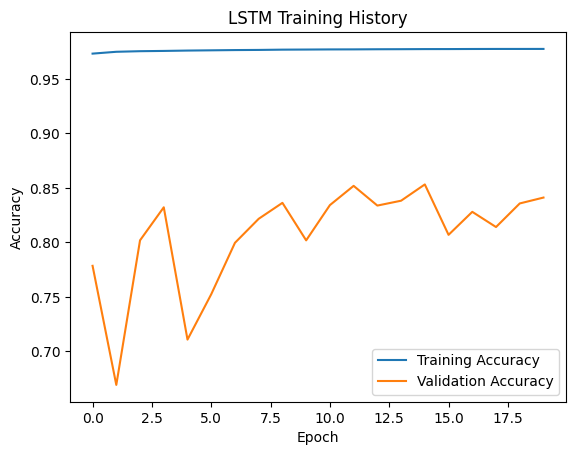

In [79]:
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("lstm_training_history")

In [ ]:
# Membuat model RNN untuk multi-kelas tanpa data dari Autoencoder
# encoding_dim = 78
# rnn_model = tf.keras.Sequential([
#     layers.Input(shape=(encoding_dim,)),
#     layers.Reshape((encoding_dim, 1)),
#     layers.LSTM(256, return_sequences=True),
#     layers.Dropout(0.4),
#     layers.LSTM(128),
#     layers.Dropout(0.4),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(num_classes, activation='softmax')  # Output layer untuk multi-kelas
# ])

# # Compile RNN
# rnn_model.compile(optimizer='adam',
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])

# # Training RNN dengan early stopping
# early_stopping_rnn = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=5,
#     restore_best_weights=True
# )

# print("\nTraining RNN...")
# history_rnn = rnn_model.fit(X_train, y_train,
#                            epochs=50,
#                            batch_size=512,
#                            validation_split=0.2,
#                            callbacks=[early_stopping_rnn])


In [ ]:
rnn_model.summary()

## Evaluasi Model pada Data Test

In [80]:
# Evaluasi model
y_pred_prob = rnn_model.predict(X_test_seq)
y_pred_classes = (y_pred_prob > 0.5).astype(int)
y_test_classes = y_test_seq

# Tampilkan hasil evaluasi
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

6940/6940 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step

Classification Report:
              precision    recall  f1-score   support

      ATTACK       0.93      0.81      0.86    128162
      BENIGN       0.78      0.91      0.84     93918

    accuracy                           0.85    222080
   macro avg       0.85      0.86      0.85    222080
weighted avg       0.86      0.85      0.85    222080



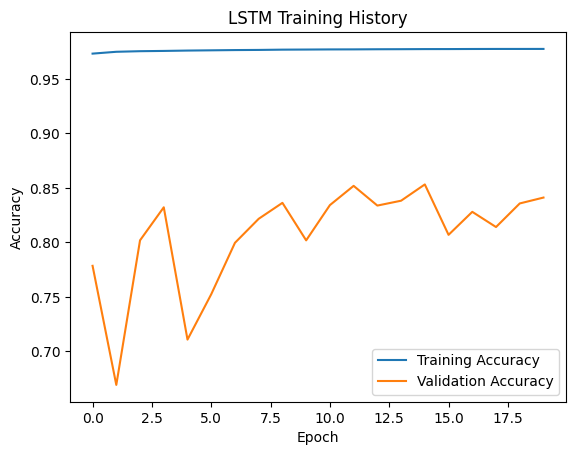

In [81]:
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("lstm_training_history")

In [82]:
# Simpan model
print("\nMenyimpan model...")
# autoencoder.save('autoencoder_model.h5')
# encoder.save('encoder_model.h5')
rnn_model.save('rnn_model.keras')


Menyimpan model...


In [83]:
# Simpan label encoder
import joblib
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(imputer, 'imputer.joblib')
joblib.dump(selector, 'selector.joblib')

['selector.joblib']

---